# Crossvalidation experiments with KuHar train and MotionSense train as base and Charm test as target


## Common imports and definitions

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys                # For include librep package

# This must be done if librep is not installed via pip,
# as this directory (examples) is appart from librep package root
sys.path.append("..")

In [2]:
# Third party imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE


# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform, ArrayMultiModalDataset
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-03 15:03:09.270888: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 15:03:09.270909: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading data from KuHar dataset

In [3]:
# Path for KuHar resampled to 20Hz view with the same activities (and labels numbers)
# It is assumed that the directory will contain (train.csv, test.csv and validation.csv)
dataset_path = Path("../../../../data/views/KuHar/resampled_view_20Hz")

Once paths is defined, we can load the CSV as pandas dataframes

In [4]:
# Kuhar dataframes
train_base, validation_base, test_base = PandasDatasetsIO(dataset_path).load()

Letś take a look in the train dataframes

In [5]:
train_base.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1


## Creating a Librep dataset from pandas dataframes

Change the features to use in other datasets

In [6]:
# Kuhar features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

df1 = train_base.query("`normalized activity code` == 0 or `normalized activity code` == 1 or `normalized activity code` == 2 or `normalized activity code` == 3  or `normalized activity code` == 4 or `normalized activity code` == 5")

In [7]:
df1.head()

,Unnamed: 0,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,normalized activity code
0,0,0.001911,-0.014536,0.005845,0.003675,-0.014972,0.025607,0.000478,-0.031141,-0.014827,...,23.235,23.223,26.260,26.249,0,300,1,2100,1051,1
1,1,0.004114,-0.003186,0.000759,0.012450,-0.032074,0.007270,-0.000470,0.006980,0.021400,...,56.292,56.292,59.245,59.245,0,300,1,5700,1037,1
2,2,-0.011282,-0.002432,-0.003199,0.008152,-0.021763,0.000309,-0.004968,-0.009551,0.001497,...,27.268,27.267,30.290,30.291,0,300,1,2700,1075,1
3,3,-0.009241,-0.004666,0.021606,-0.007200,0.003091,0.001630,0.005057,-0.008149,0.013167,...,39.421,39.420,42.441,42.440,0,300,6,3900,1008,1
4,4,-0.013083,-0.005612,0.001645,0.006823,-0.004159,0.000415,0.008178,0.002637,-0.000827,...,23.703,23.703,26.656,26.656,0,300,1,2400,1038,1


In [8]:
# Creating the train dataset

train_dset1 = PandasMultiModalDataset(
    df1,
    feature_prefixes=features,
    label_columns="normalized activity code",
    as_array=True
)

## Inspect sample

In [9]:
# Lets print the first sample of combined_train dataset.
# Is a tuple, with an vector of 360 elements as first element and the label as second
x = train_dset1[0]
#print(x)

In [10]:
# Inspecting sample
print(f"The sample 0: {x[0]}")
print(f"Shape of sample 0: {x[0].shape}")
print(f"The label of sample 0: {x[1]}")

The sample 0: [ 1.91093286e-03 -1.45361925e-02  5.84452385e-03  3.67495627e-03
 -1.49718059e-02  2.56068907e-02  4.77538088e-04 -3.11405362e-02
 -1.48270261e-02  7.69834863e-03  1.06101665e-02 -5.96475630e-02
 -3.35511310e-03 -1.65885925e-03  3.94389738e-02 -4.28711994e-02
 -4.65577088e-03 -1.44686791e-02 -7.36948774e-03 -3.87024460e-03
  6.24744252e-02 -1.79626835e-02  3.22744928e-03 -3.75961022e-03
  1.46163449e-02 -1.07502353e-02 -9.27218103e-03  5.06417325e-03
  1.40691624e-02  1.60138354e-02 -5.34838152e-02 -3.29858611e-03
  2.31031426e-02  2.27906805e-02  2.54595798e-03  1.75255266e-02
 -5.10498318e-03 -2.07463519e-02  1.32902011e-02  1.37572046e-02
  7.17675958e-03 -2.01445217e-02  5.47817384e-03 -7.66570074e-04
  1.94831071e-02 -1.11694213e-03  2.27235363e-02 -1.49616813e-02
 -9.71672954e-03 -7.12839038e-03  9.02811373e-03 -1.57676951e-03
 -5.51378813e-03 -3.61854449e-03 -9.16178207e-03  1.69776410e-02
 -3.65341848e-03 -2.29361283e-02 -2.51271512e-03  3.50588067e-02
  1.3409791

## Loading data from MotionSense

In [11]:
dataset_path = Path("../../../../data/views/MotionSense/resampled_view_20Hz")

In [12]:
# Motionsense dataframe
train_base, validation_base, test_base = PandasDatasetsIO(dataset_path).load()

In [13]:
train_base.head()

,Unnamed: 0,userAcceleration.x-0,userAcceleration.x-1,userAcceleration.x-2,userAcceleration.x-3,userAcceleration.x-4,userAcceleration.x-5,userAcceleration.x-6,userAcceleration.x-7,userAcceleration.x-8,...,rotationRate.z-56,rotationRate.z-57,rotationRate.z-58,rotationRate.z-59,activity code,length,trial_code,index,user,normalized activity code
0,0,-0.101581,-0.221355,-0.234016,-0.264552,-0.200991,-0.208962,-0.308408,0.089943,-0.382516,...,-0.171130,0.292608,0.932535,0.782147,0,150,1,150,11,4
1,1,-0.082527,0.201136,-0.017408,0.120404,-0.179599,-0.013960,-0.014233,0.253264,0.684288,...,0.241819,0.718420,0.336507,0.936563,0,150,1,900,12,4
2,2,0.108323,-0.045941,0.017410,0.010881,0.019035,-0.157225,0.016889,-0.076276,0.149599,...,0.732298,0.667477,-0.025386,-0.037093,0,150,1,1050,21,4
3,3,-0.370755,-0.495850,0.205895,0.455012,0.113117,-0.327512,0.111760,0.001935,-0.844532,...,0.037076,-0.993926,-0.182277,0.317828,0,150,2,150,17,4
4,4,-0.005683,0.452370,0.028475,0.402016,0.168378,0.353346,0.182684,0.042545,0.001530,...,0.496173,1.265226,1.502311,0.857408,0,150,11,450,21,4


In [14]:
# MotionSense features to select
features = [
    "userAcceleration.x",
    "userAcceleration.y",
    "userAcceleration.z",
    "rotationRate.x",
    "rotationRate.y",
    "rotationRate.z"
]

# Creating the target dataset

train_dset2 = PandasMultiModalDataset(
    train_base,
    feature_prefixes=features,
    label_columns="normalized activity code",
    as_array=True
)

In [15]:
x = train_dset2[0]

In [16]:
print(f"The sample 0: {x[0]}")
print(f"Shape of sample 0: {x[0].shape}")
print(f"The label of sample 0: {x[1]}")

The sample 0: [-1.01580660e-01 -2.21355124e-01 -2.34015566e-01 -2.64551900e-01
 -2.00990656e-01 -2.08961907e-01 -3.08408466e-01  8.99426214e-02
 -3.82515554e-01 -7.75533852e-02  1.46318283e-01 -4.93770905e-02
 -2.09640201e-02 -3.17307189e-02 -3.74259464e-01 -1.52182310e-01
  1.05233312e-01  1.11319758e-01 -5.38330158e-02 -3.14136807e-01
 -2.08472528e-01 -3.23492282e-01 -1.91815150e-01 -1.88533126e-01
 -4.71212234e-01 -3.96779870e-01  5.07970584e-01  5.27352561e-02
  1.59006497e-01  3.15998485e-02 -1.98139909e-01  2.08691866e-01
 -1.08432318e-01 -4.06142257e-01  1.66143634e-01  7.70059198e-06
 -5.77953517e-02 -5.52501402e-02 -2.20866812e-01 -3.14509600e-01
  2.84967949e-01  1.34890424e-01  6.60941177e-02  6.91335728e-02
 -3.98362725e-01  6.46615090e-02  1.24072879e-01 -2.26239499e-01
 -3.26437858e-01 -1.39575067e-01 -1.09824066e-02 -7.93132478e-02
 -4.57364775e-01 -1.14570859e-01  2.62746376e-01 -1.53196322e-01
  3.57891496e-01 -2.31041538e-01 -2.26239680e-01  3.22787316e-01
 -1.4633490

## Fourier Transform

In [17]:
#fft_transform = FFT(centered = True)
fft_transform = FFT()
transformer = TransformMultiModalDataset(transforms=[fft_transform], new_window_name_prefix="fft.")

### Use FFT in the base dataset

In [18]:
train_dset1_fft = transformer(train_dset1)
train_dset2_fft = transformer(train_dset2)

In [19]:
train_dset1[:][0]

array([[ 1.91093286e-03, -1.45361925e-02,  5.84452385e-03, ...,
         3.45654902e-03,  2.32869360e-03,  4.45589801e-03],
       [ 4.11395657e-03, -3.18646610e-03,  7.58931558e-04, ...,
        -9.94428406e-04, -1.82853273e-03,  2.97903419e-03],
       [-1.12820040e-02, -2.43180090e-03, -3.19908050e-03, ...,
         3.56838998e-03,  4.38234273e-03,  3.34301636e-03],
       ...,
       [ 8.12635211e-01, -2.95986593e+00, -3.61014307e-01, ...,
        -1.47121709e-01, -3.81574833e-02,  2.16763545e-04],
       [ 7.72943092e+00,  2.10744868e-01, -5.15993698e+00, ...,
         3.03075311e-01,  4.89441743e-01, -5.05172457e-01],
       [-2.44054183e+00, -3.69217056e+00, -4.24268425e+00, ...,
        -1.86095810e-01, -4.67283624e-03,  9.00143926e-01]])

In [20]:
train_dset1_fft[:][0]

array([[2.08923330e-02, 1.12081089e-01, 6.03699767e-02, ...,
        5.31635769e-02, 3.12414586e-02, 1.40369727e-01],
       [1.53802877e-02, 8.24343989e-02, 4.18766153e-02, ...,
        9.66322286e-03, 2.59289385e-02, 2.52929170e-02],
       [5.21272671e-02, 4.82816195e-02, 8.93573044e-02, ...,
        1.93188738e-02, 4.41668326e-02, 6.26341618e-02],
       ...,
       [6.24426448e+00, 1.15978106e+01, 1.45006698e+01, ...,
        2.75883699e+00, 3.48783245e+00, 6.42606165e+00],
       [3.62577187e+00, 8.69724063e+00, 4.51392321e+00, ...,
        2.97882638e+00, 7.54758380e-01, 2.10283757e+00],
       [5.54672876e+00, 2.40077674e+01, 2.79418421e+01, ...,
        5.83598542e+00, 2.05713559e+01, 3.34078637e+00]])

In [21]:
train_dset2[:][0]

array([[-0.10158066, -0.22135512, -0.23401557, ...,  0.29260805,
         0.932535  ,  0.78214699],
       [-0.08252731,  0.20113614, -0.017408  , ...,  0.71842028,
         0.33650671,  0.93656304],
       [ 0.10832292, -0.04594076,  0.01741017, ...,  0.66747733,
        -0.0253858 , -0.03709332],
       ...,
       [ 0.19266143,  0.10970878,  0.28033436, ..., -0.39853684,
        -0.17416418, -0.04600792],
       [ 0.69634911,  1.57399343, -0.05390784, ...,  2.05972956,
         3.92681916,  1.76309344],
       [-0.69489245,  0.10504003,  0.50498891, ..., -2.74187909,
        -3.1827423 , -3.9243559 ]])

In [22]:
train_dset2_fft[:][0]

array([[ 5.2349672 ,  1.31500631,  0.62294979, ...,  7.47277363,
         3.77121234,  9.62952042],
       [ 0.4195556 ,  1.47781888,  0.7555246 , ...,  0.83487658,
         0.4655761 ,  2.86996899],
       [ 2.1285244 ,  1.03841388,  0.40157264, ...,  3.07408871,
        14.93903516,  1.93762252],
       ...,
       [ 1.42114   ,  0.65160823,  1.25705442, ...,  5.28984981,
         2.99527632,  0.63238641],
       [ 4.8760868 ,  3.38651808,  3.43928376, ..., 11.70903288,
         3.30989796,  6.74709235],
       [ 8.1994832 ,  1.53695342,  3.1026772 , ...,  1.34573442,
         1.37521237,  2.29600078]])

In [23]:
combined_train_dsetX = np.concatenate((train_dset1_fft.X, train_dset2_fft.X))
combined_train_dsety = np.concatenate((train_dset1_fft.y, train_dset2_fft.y))

In [24]:
print(len(train_dset1_fft.X))
print(len(train_dset2_fft.X))
print(len(combined_train_dsetX))
print(len(train_dset1_fft.y))
print(len(train_dset2_fft.y))
print(len(combined_train_dsety))

1110
3414
4524
1110
3414
4524


In [25]:
combined_train_dset_fft = ArrayMultiModalDataset(
    X = combined_train_dsetX,
    y = combined_train_dsety,
    window_slices = train_dset1_fft.window_slices,
    window_names = train_dset1_fft.window_names
)

## Loading data from the Charm dataset

In [26]:
dataset_path = Path("../../../../data/views/CHARM/unbalanced_view_train_test-v1")

In [27]:
train_target,validation_target, test_target = PandasDatasetsIO(dataset_path).load(load_validation = False)

In [28]:
test_target.shape

(747, 362)

In [29]:
train_target.head()

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user
0,-0.316044,-2.499959,-0.616105,0.353358,-0.824398,-0.810047,-1.138340,-1.589111,-1.370696,-0.703873,...,5.126820,5.147284,5.167496,5.180790,5.222275,5.303915,5.373075,5.411260,0,0
1,-0.050466,0.074350,0.097396,0.084905,0.112700,0.134203,0.110953,0.088282,0.177306,0.145449,...,5.044690,5.111729,5.150032,5.159996,5.156902,5.147285,5.131298,5.108950,0,0
2,0.270301,0.028054,0.146652,0.376342,0.164298,0.253816,0.245170,0.202514,0.265768,0.320114,...,5.288892,5.437164,5.572677,5.670806,5.707042,5.675314,5.608472,5.544296,0,0
3,-0.683588,-1.033685,-1.154929,-0.492721,0.061972,0.130619,0.385515,0.393008,0.082072,-0.764478,...,5.360652,5.380427,5.405318,5.438172,5.481835,5.538151,5.597009,5.640450,0,0
4,-0.185709,-0.083570,-0.230019,-0.157817,-0.349459,-0.400257,-0.079761,-0.236021,-0.043397,0.095293,...,4.510063,4.722800,4.969438,5.028447,4.880812,4.689925,4.580247,4.548837,0,0


In [30]:
# Charm features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

df2 = test_target.query("`activity code` == 0 or `activity code` == 2 or `activity code` == 6 or `activity code` == 7  or `activity code` == 8 or `activity code` == 9")
df2.loc[ df2['activity code'] == 2, 'activity code'] = 1
df2.loc[ df2['activity code'] == 6, 'activity code'] = 2
df2.loc[ df2['activity code'] == 7, 'activity code'] = 5
df2.loc[ df2['activity code'] == 8, 'activity code'] = 3
df2.loc[ df2['activity code'] == 9, 'activity code'] = 4

# Creating the target dataset

combined_target_dset = PandasMultiModalDataset(
    df2,
    feature_prefixes=features,
    label_columns="activity code",
    as_array=True
)

In [31]:
# Lets print the first sample of combined_target dataset.
# Is a tuple, with an vector of 180 elements as first element and the label as second
x = combined_target_dset[0]
#print(x)

In [32]:
# Inspecting sample
print(f"The sample 0: {x[0]}")
print(f"Shape of sample 0: {x[0].shape}")
print(f"The label of sample 0: {x[1]}")

The sample 0: [ 1.87944829e+00  1.50068061e+00 -1.17416891e+00 -1.63050043e+00
 -9.98362158e-02  5.97497177e-01 -1.03199297e-01 -1.06137448e+00
 -2.03510368e-01  9.31233135e-01 -2.53537097e-01 -5.97317508e-01
  2.23946407e-02 -2.87698868e-01 -4.23952946e-01 -2.20995923e-01
 -5.40730951e-01 -7.79622158e-01 -3.10373885e-01 -7.78201796e-02
 -1.91536129e-01 -3.67901020e-01 -3.95327830e-01 -2.94539173e-01
 -2.46602758e-01 -2.55659571e-01 -1.51975356e-01 -2.05079565e-01
 -2.17872624e-01 -8.15989717e-02 -1.71751656e-01 -1.36469259e-01
 -8.85855732e-02 -1.07123667e-01 -1.30025432e-01 -3.05427147e-02
 -4.30956451e-02 -7.07542952e-02 -1.31583845e-01 -2.46879676e-02
 -7.15807585e-02 -1.68072876e-01 -5.39208067e-02 -3.29528033e-03
 -1.12527472e-01  6.89147182e-03  3.14136569e-02 -1.11927425e-01
 -4.07016272e-02 -2.88306305e-02  2.34176567e-02 -3.67251084e-03
  4.82252363e-03  3.29031419e-02 -1.65013217e-02  6.68134837e-02
  1.19708976e-02 -2.54084684e-02  8.24511029e-02  2.10305958e-02
  5.3010616

In [33]:
combined_target_dset_fft = transformer(combined_target_dset)

In [34]:
combined_target_dset[:][0]

array([[ 1.87944829,  1.50068061, -1.17416891, ...,  7.72830181,
         7.66321511,  7.57120856],
       [ 0.01197101,  0.0967018 , -0.04273273, ...,  7.53286364,
         7.54338057,  7.5760129 ],
       [ 0.06472003,  0.10195188,  0.10602116, ...,  7.50742964,
         7.50572595,  7.52225666],
       ...,
       [-0.47404369, -0.3986834 , -0.43612399, ...,  8.64720219,
         8.68311106,  8.7196136 ],
       [-1.24789887, -0.8501501 , -1.35272704, ...,  8.76017322,
         8.7895205 ,  8.82693673],
       [ 0.01265234,  0.22420561,  0.48105313, ...,  8.42447764,
         8.40711837,  8.3908002 ]])

In [35]:
combined_target_dset_fft[:][0]

array([[ 6.53082306,  5.6577835 ,  3.15349354, ...,  5.08795376,
         3.03887515,  1.9845463 ],
       [ 4.32410452,  1.93090761,  0.87353843, ...,  5.10809627,
         4.50655888,  4.03933227],
       [ 5.41211807,  0.30829857,  0.16752287, ...,  0.65164456,
         0.6673181 ,  0.23774085],
       ...,
       [26.62151361,  3.61671748,  0.93254938, ...,  3.61226287,
         5.34808751, 23.1509465 ],
       [33.68420885, 17.41583015, 12.51879572, ...,  5.98775019,
        14.99849678, 16.83496193],
       [ 3.47504891, 13.78404589,  1.76783046, ...,  1.71589954,
         2.97010164,  9.59298592]])

In [36]:
print(len(combined_target_dset_fft))
print(len(combined_target_dset))

405
405


## Train and evaluate Random Forest classifier

In [37]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    #normalize='true'
)

experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier, 
    estimator_creation_kwags ={'n_estimators':100}, 
    do_not_instantiate=False, 
    do_fit=True, 
    evaluator=reporter)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


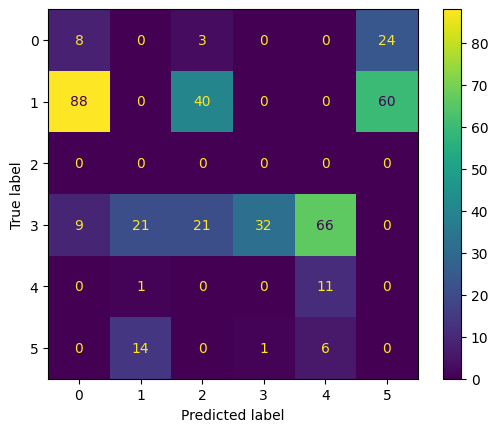

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


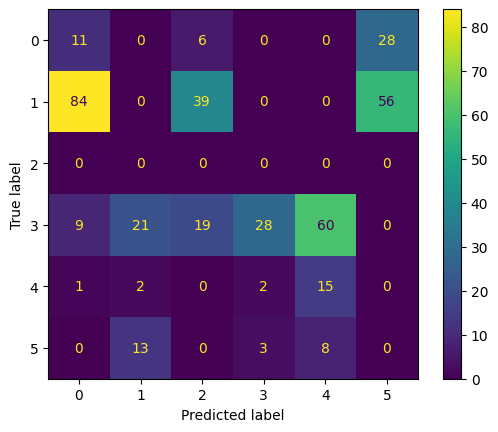

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


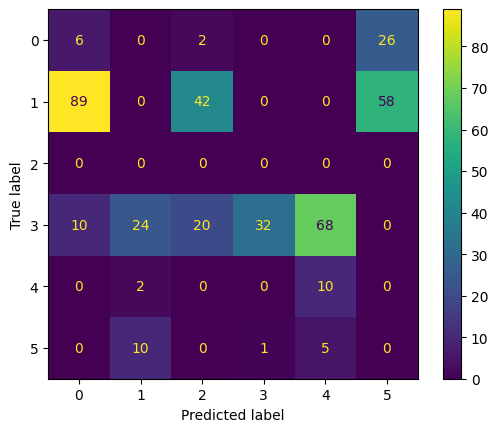

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


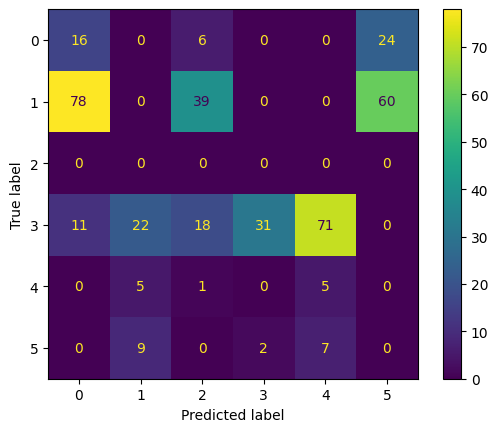

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


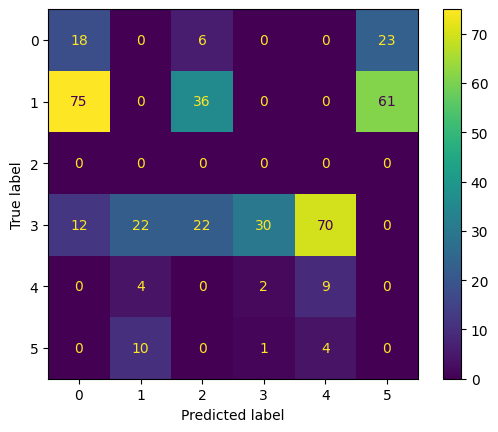

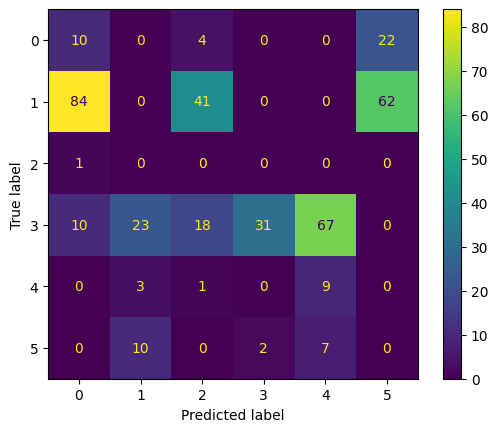

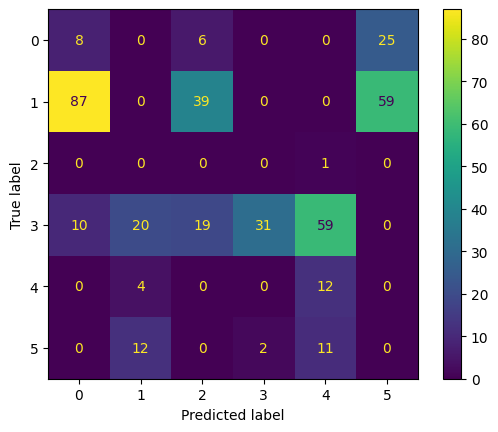

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


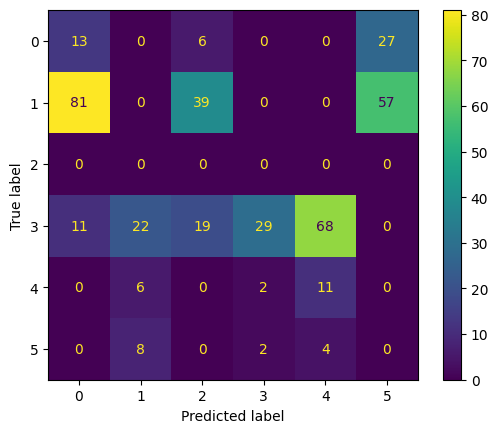

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


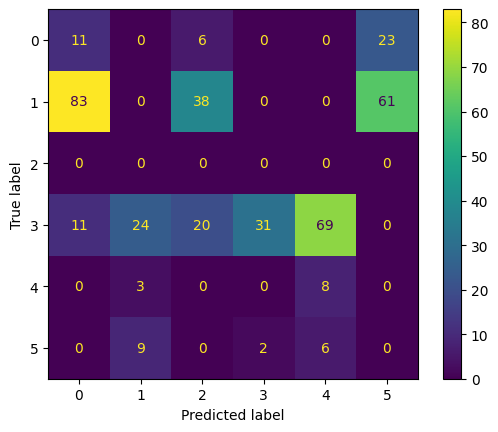

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


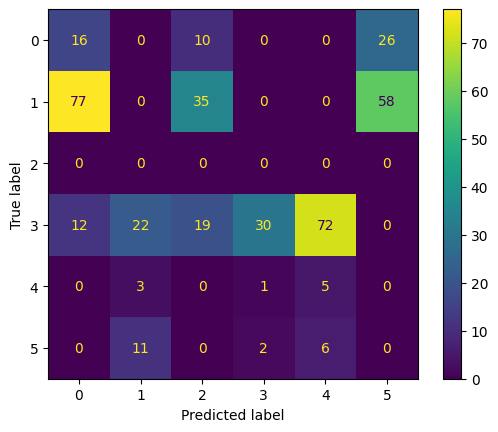

Mean accuracy (10 runs): 0.1277. Mean f1-score: 0.1473
Standard deviation accuracy (10 runs): 0.0058. Standard deviation f1-score: 0.0044


In [38]:
results = multi_run_experiment(combined_train_dset_fft, combined_target_dset_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Train and evaluate Support Vector Machine classifier

In [39]:
experiment = SimpleTrainEvalWorkflow(estimator=SVC, estimator_creation_kwags ={'C':3.0, 'kernel':"rbf"} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


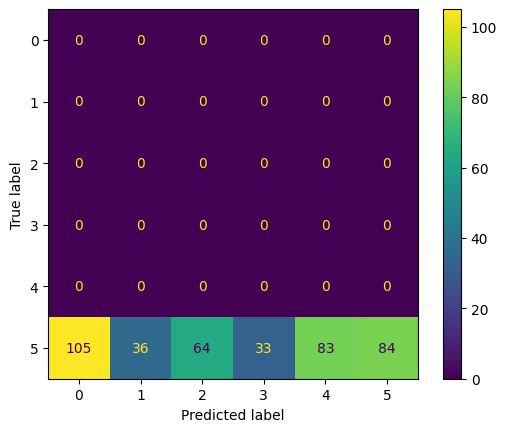

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


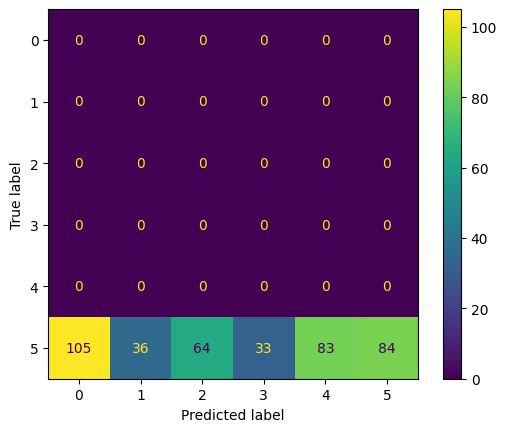

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


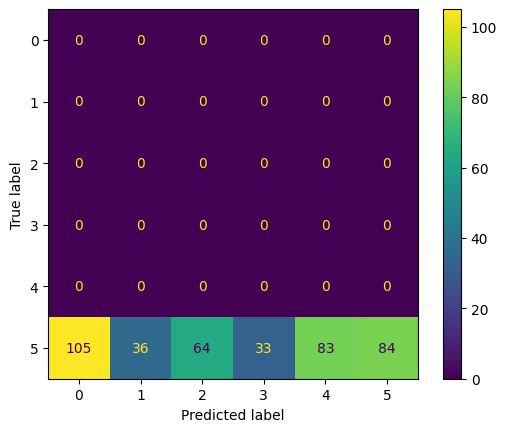

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


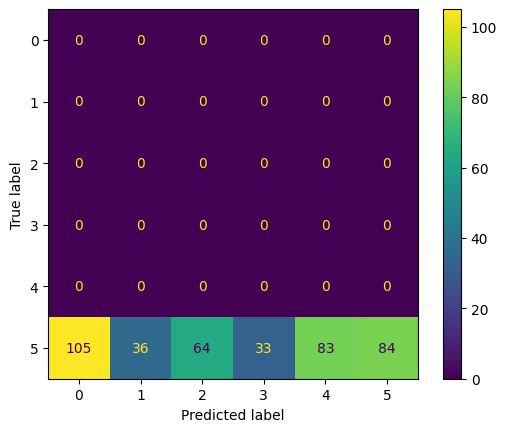

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


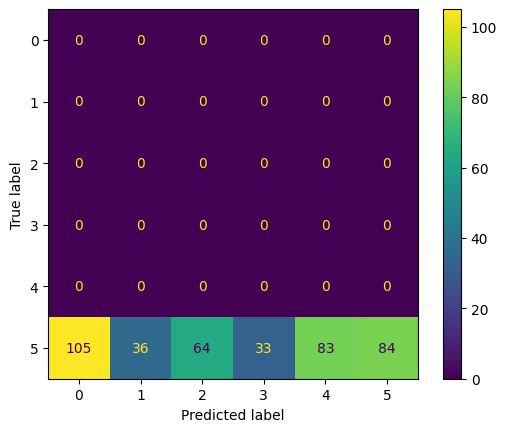

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


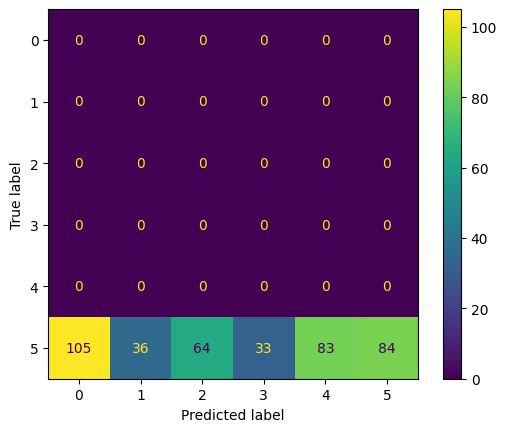

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


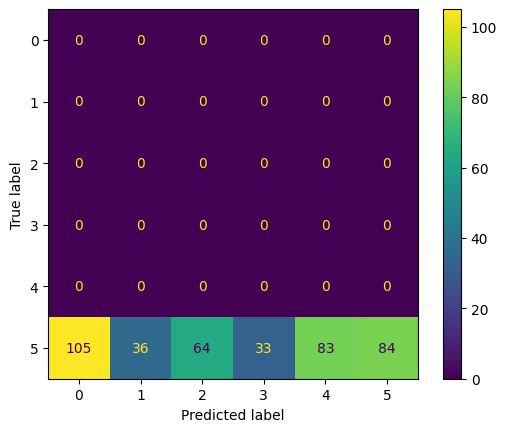

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


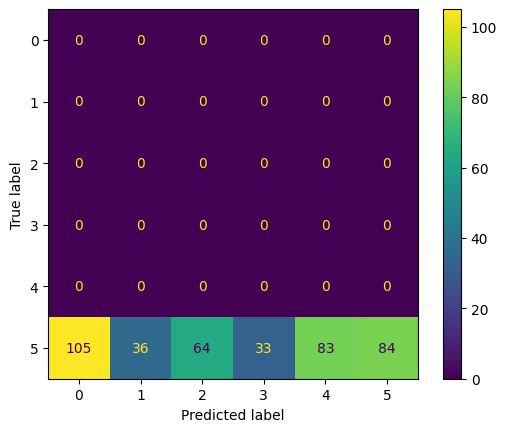

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


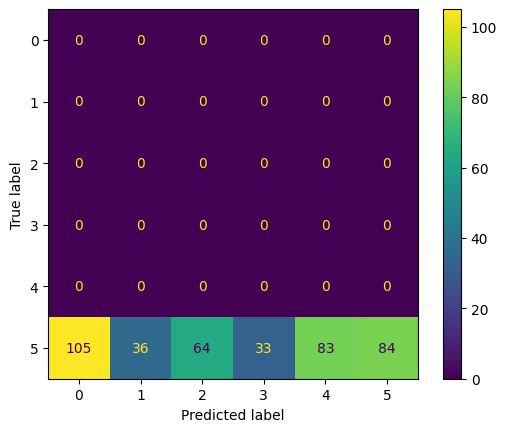

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


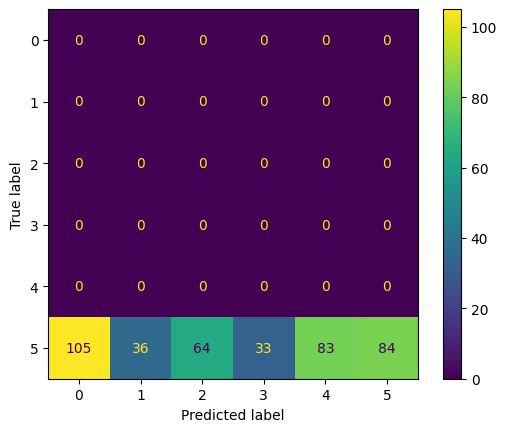

Mean accuracy (10 runs): 0.2074. Mean f1-score: 0.3436
Standard deviation accuracy (10 runs): 0.0000. Standard deviation f1-score: 0.0000


In [40]:
results = multi_run_experiment(combined_train_dset_fft, combined_target_dset_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")

## Train and evaluate K Neighbors Classifier classifier

In [41]:
experiment = SimpleTrainEvalWorkflow(estimator=KNeighborsClassifier, estimator_creation_kwags ={'n_neighbors' :1} , do_not_instantiate=False, do_fit=True, evaluator=reporter)
multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


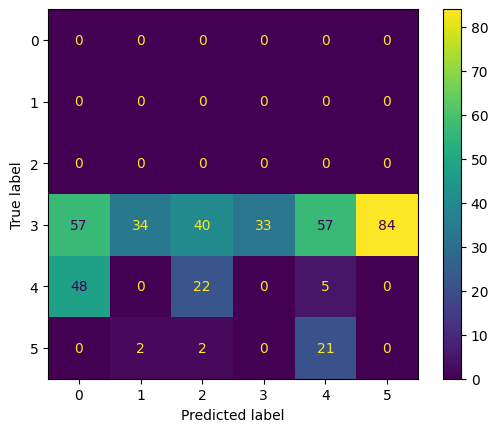

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


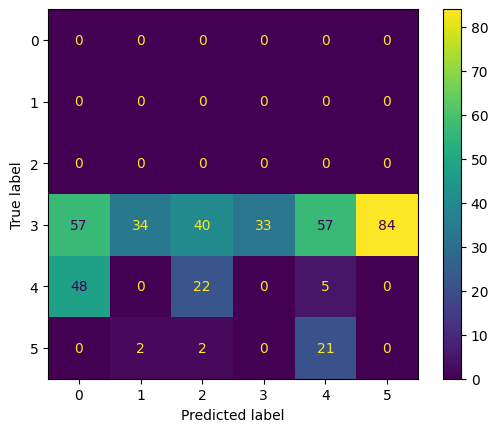

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


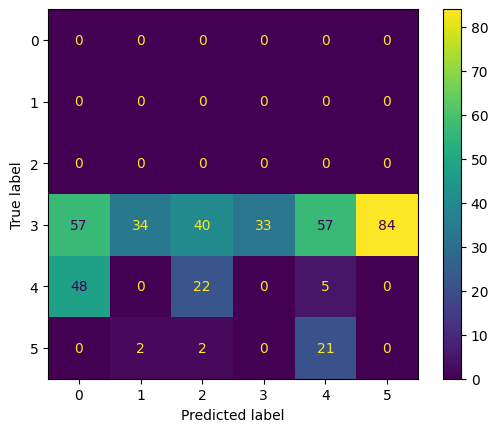

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


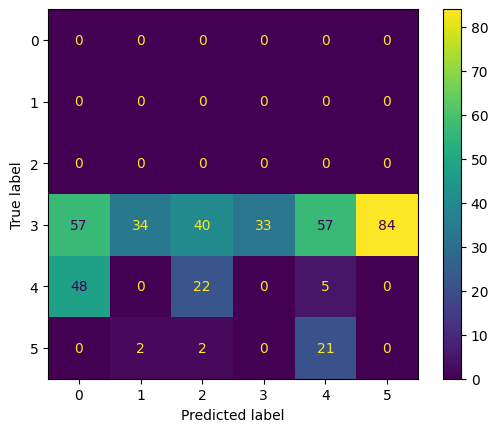

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


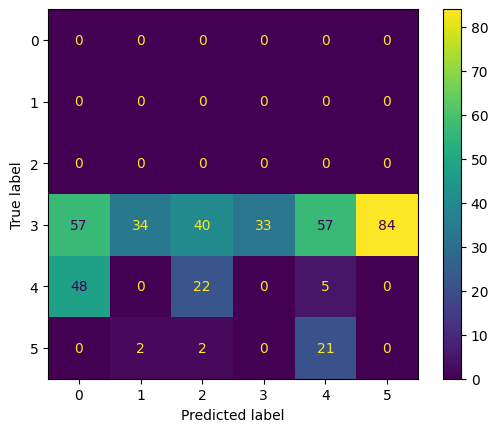

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


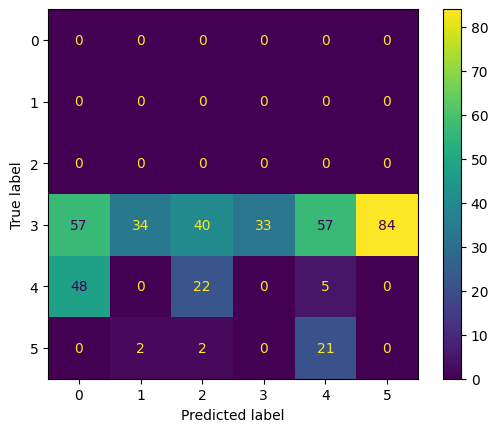

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


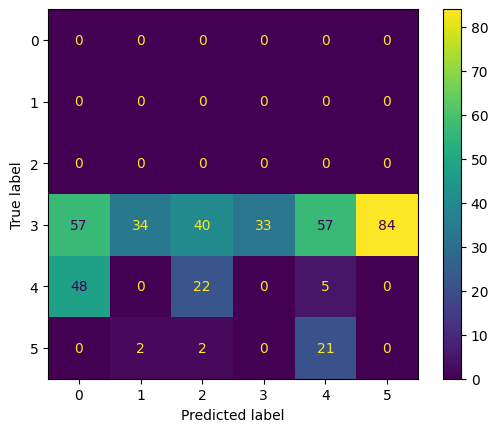

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


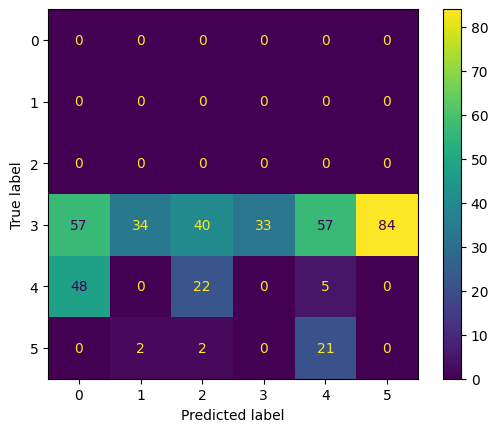

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


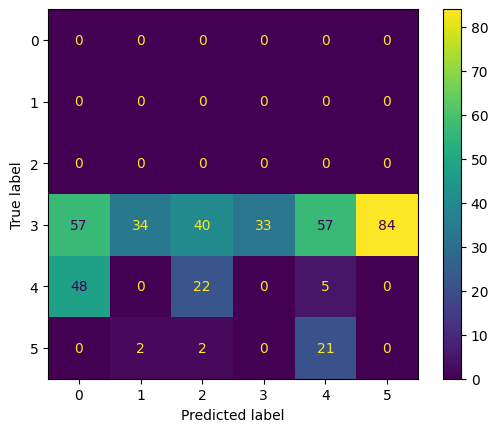

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


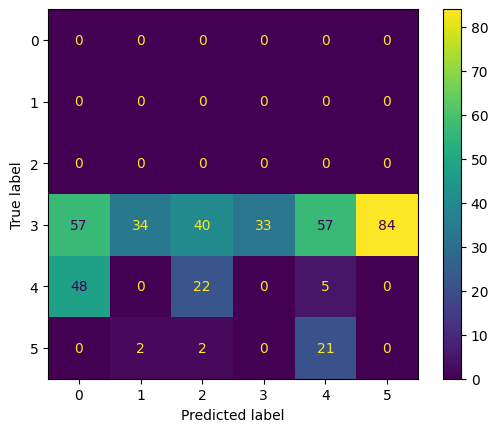

Mean accuracy (10 runs): 0.0938. Mean f1-score: 0.1588
Standard deviation accuracy (10 runs): 0.0000. Standard deviation f1-score: 0.0000


In [42]:
results = multi_run_experiment(combined_train_dset_fft, combined_target_dset_fft)

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)
mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}")
print(f"Standard deviation accuracy (10 runs): {std_acc:.4f}. Standard deviation f1-score: {std_f1:.4f}")